In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import torch.distributions as tdist
import sys
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from scipy.stats import norm
# matplotlib options
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

## First, lets load in some data:

Note that this loads in preprocessed data. 4 examples is included at the GitHub repository. 

Fraction of boundary cases: 0.019
Fraction of problematic cases: 0.010


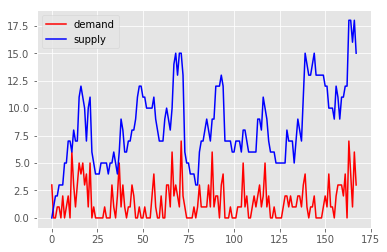

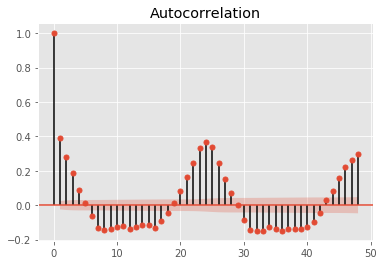

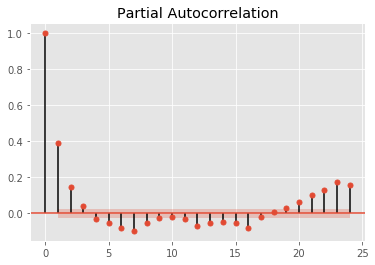

In [2]:
#Read in the pre-processed data
df = pd.read_csv('prepared/demand_supply/10244.csv')
#Baseline
df.time = pd.to_datetime(df.time)
demand_ts = [df.demand[t] for t in range(len(df))]
supply_ts = [df.supply[t] for t in range(len(df))]
print("Fraction of boundary cases: %.3f" % (np.sum(np.array(demand_ts) == np.array(supply_ts)) / len(demand_ts)),)
print("Fraction of problematic cases: %.3f" % (np.sum(np.array(demand_ts) > np.array(supply_ts)) / len(demand_ts)),)
plt.plot(demand_ts[:(24*7)], "r-")
plt.plot(supply_ts[:(24*7)], "b-")
plt.legend(["demand", "supply"], loc="upper left")
plt.show()

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_acf(df.demand, lags=48)
plot_pacf(df.demand, lags=24)
plt.show()

In [3]:
## Add more data from other zones:

df2 = pd.read_csv('prepared/demand_supply/10222.csv')
df2.time = pd.to_datetime(df.time)

df3 = pd.read_csv('prepared/demand_supply/10234.csv')
df3.time = pd.to_datetime(df.time)

df4 = pd.read_csv('prepared/demand_supply/17304.csv')
df4.time = pd.to_datetime(df.time)

df = pd.concat([df,df2,df3,df4], axis = 0).reset_index(drop=True)
df.time = pd.to_datetime(df.time)



## One-hot encoding of categorical data

In [4]:
for i in range(df.shape[0]):
    if df.demand[i] > df.supply[i]:
        df.supply[i] = df.demand[i]
        
dim = df.shape[0]

ToD = [df.time[i].hour for i in range(dim)]
DoW = [df.time[i].weekday() for i in range(dim)]
DoM = [df.time[i].day for i in range(dim)]
Month = [df.time[i].month for i in range(dim)]
df['ToD'] = ToD
df['DoW'] = DoW
df['DoM'] = DoM
df['Month'] = Month

df = df[['Month','DoM','DoW','ToD','demand','supply']].sort_values(['Month', 'DoM','DoW','ToD']).reset_index(drop=True)
Days = ['Mon', 'Tue','Wed','Thu','Fri','Sat','Sun']
#df.DoW = [Days[each] for each in df.DoW]
#Converting to categorical - the month and date is excluded for now
df = pd.concat([df, pd.get_dummies(df.DoW), pd.get_dummies(df.ToD)], axis = 1)
df.head(20)

C:\Users\marti\AppData\Local\conda\conda\envs\sandbox\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Month,DoM,DoW,ToD,demand,supply,0,1,2,3,...,14,15,16,17,18,19,20,21,22,23
0,1,1,0,0,5,15,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,3,13,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,9,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,8,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,3,11,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,1,0,1,3,14,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,1,0,1,1,9,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,1,0,1,0,8,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,1,0,2,0,9,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,1,0,2,0,10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Establish training, validation and test data

We keep 80% of the data for training, and 10% each for validation and testing. Since we have time-series data, we do not want to randomly permute our data, but instead keep the sequences unbroken. 

In [5]:
X = df.iloc[:,6:]
y = df.demand
z = df.supply

#Prepare data for training
X = np.asarray(X)
y = np.asarray(y)
z = np.asarray(z)

  
X_lag = np.transpose(np.asmatrix([np.roll(y,1), np.roll(y,2), np.roll(y,3), np.roll(y,4), np.roll(y,5), np.roll(y,6), np.roll(y,7), np.roll(y,8), np.roll(y,9), np.roll(y,10), np.roll(y,11), np.roll(y,12), np.roll(y,13), np.roll(y,14), np.roll(y,15), np.roll(y,16), np.roll(y,17), np.roll(y,18), np.roll(y,19), np.roll(y,20), np.roll(y,21), np.roll(y,22), np.roll(y,23), np.roll(y,24)]))
X_lag = np.expand_dims(X_lag, axis = 2)

obs, time_steps, lag_dim = X_lag.shape
num_features = X.shape[1]

train_idx, val_idx = int(obs*0.8), int(obs*0.9)

x_train = X[:train_idx,:].astype('float32')
x_train_lag = X_lag[:train_idx,:].astype('float32')
targets_train = y[:train_idx].astype('float32')
supply_train = z[:train_idx].astype('float32')

x_valid = X[train_idx:val_idx,:].astype('float32')
x_valid_lag = X_lag[train_idx:val_idx,:].astype('float32')
targets_valid = y[train_idx:val_idx].astype('float32')
supply_valid = z[train_idx:val_idx].astype('float32')

x_test = X[val_idx:,:].astype('float32')
x_test_lag = X_lag[val_idx:,:].astype('float32')
targets_test = y[val_idx:].astype('float32')
supply_test = z[val_idx:].astype('float32')

## Define the model

We can now define our two-branch model:

In [6]:
use_cuda = torch.cuda.is_available()

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

In [7]:
use_cuda = False
batch_size = 128
hidden_rnn = 100
hidden_FF = 126

In [9]:
class Net(nn.Module):

    def __init__(self, seq_len, hidden_rnn, hidden_FF):
        super().__init__()
        
        self.num_layers = 1
        self.hidden_rnn = hidden_rnn
        
        self.rnn = nn.LSTM(lag_dim, hidden_rnn, self.num_layers, batch_first = True)
        self.rnn_dense = nn.Linear(in_features = self.hidden_rnn, out_features = self.hidden_rnn)
        self.rnn_dense2 = nn.Linear(in_features = self.hidden_rnn, out_features = 1)
        
        self.FF_dense1 = nn.Linear(in_features=num_features, out_features= hidden_FF, bias=True)
        self.FF_dense2 = nn.Linear(in_features=hidden_FF, out_features = 1, bias = True)
        
        
        self.output = nn.Linear(in_features = 2, out_features = 1, bias = True)
        
        
        self.dropout = Dropout(0.3)
        self.BatchNormLag = BatchNorm1d(seq_len)
        self.BatchNormFeatures = BatchNorm1d(num_features)
        
        
    def forward(self, time_series, cat_inputs, h0, c0):
        # Input shape [batch, seq_in_len, num_layers]
        
        output_rnn, (hn, cn) = self.rnn(time_series, (h0, c0))
        
        out_rnn = self.dropout(self.rnn_dense(hn[-1]))
        out_rnn = self.rnn_dense2(out_rnn) # This now has the rnn-prediction for each batch-input
      
        #"If you need a fixed number of output features you either set hidden_size to that value, 
        #or you add an output layer that maps from hidden_size to your output space."
        
        # Lets combine it with a FFNN for the categorical inputs!
        
        out_FF = self.BatchNormFeatures(cat_inputs)
        out_FF = relu(self.FF_dense1(out_FF))
        out_FF = relu(self.FF_dense2(out_FF))
        
        ## Combine contribution from both branches
        
        x = torch.cat((out_rnn, out_FF), dim=1)
        x = self.output(x)
        
        return x

    def init_hidden(self, batch_size):
        init = Variable(torch.randn(self.num_layers, batch_size, self.hidden_rnn)).float()
        return init
    def init_cell(self, batch_size):
        init = Variable(torch.randn(self.num_layers, batch_size, self.hidden_rnn)).float()
        return init
    
net = Net(time_steps, hidden_rnn, hidden_FF)
if use_cuda:
    net.cuda()
print(net)

Net(
  (rnn): LSTM(1, 100, batch_first=True)
  (rnn_dense): Linear(in_features=100, out_features=100)
  (rnn_dense2): Linear(in_features=100, out_features=1)
  (FF_dense1): Linear(in_features=31, out_features=126)
  (FF_dense2): Linear(in_features=126, out_features=1)
  (output): Linear(in_features=2, out_features=1)
  (dropout): Dropout(p=0.3)
  (BatchNormLag): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True)
  (BatchNormFeatures): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True)
)


Lets make sure we got the dimension right :-) 

In [10]:
#Test
print(x_train.shape)
x = Variable(torch.from_numpy(x_train[:batch_size,:])).float()
x_lag = get_variable(Variable(torch.from_numpy(x_train_lag[:batch_size,:]).float()))
print(x_lag.size())
h0 = net.init_hidden(batch_size)
c0 = net.init_cell(batch_size)
output = net(x_lag, x, c0, h0)
output


(20659, 31)
torch.Size([128, 24, 1])


Variable containing:
 0.5771
 0.5852
 0.5886
 0.5810
 0.5773
 0.5852
 0.5842
 0.5897
 0.5785
 0.5960
 0.5779
 0.5809
 0.5848
 0.5912
 0.5805
 0.5740
 0.5909
 0.5927
 0.5929
 0.5863
 0.6124
 0.6089
 0.6094
 0.6035
 0.5842
 0.5882
 0.5854
 0.5752
 0.6084
 0.6116
 0.6222
 0.6038
 0.5834
 0.5847
 0.5795
 0.5768
 0.5940
 0.6164
 0.6022
 0.6013
 0.5888
 0.5886
 0.5820
 0.5914
 0.6497
 0.6388
 0.6464
 0.6463
 0.6240
 0.6124
 0.6179
 0.6149
 0.5838
 0.5841
 0.5747
 0.5831
 0.5813
 0.5847
 0.5808
 0.5847
 0.5834
 0.5936
 0.5842
 0.5724
 0.6097
 0.6129
 0.5976
 0.6070
 0.5880
 0.5893
 0.5860
 0.5868
 0.5841
 0.5837
 0.5863
 0.5865
 0.5792
 0.5904
 0.5838
 0.5806
 0.5730
 0.5805
 0.5859
 0.5875
 0.5957
 0.5824
 0.5724
 0.5800
 0.5979
 0.5951
 0.6082
 0.6035
 0.5865
 0.5898
 0.5930
 0.5942
 0.5861
 0.5870
 0.5827
 0.5809
 0.5919
 0.5936
 0.5892
 0.5810
 0.5751
 0.5787
 0.5716
 0.5824
 0.5776
 0.5880
 0.5809
 0.5825
 0.5923
 0.5868
 0.5789
 0.5657
 0.5873
 0.5861
 0.5866
 0.5939
 0.5825
 0.5890
 0.

This is where it gets interesting. We want to define our custom loss function as in the report: 

\begin{equation} 
lnL(\beta,\sigma) = \sum_{i=1}^n \left( d_i ln[\phi(\frac{y_i - x_i\beta}{\sigma})] - ln(\sigma) + (1-d_i) ln[1 - \Phi(\frac{y_i^* - x_i\beta}{\sigma}] \right)
\end{equation}

Where the indicator variable $d_i \in \{0,1\}$ is 1 if $y_i$ < $y_i*$, and 0 otherwise, and $\phi$ and $\Phi$ is the PDF and CDF of the standard normal distribution repectively.

Notice that our case is further complicated, since the upper limit y* is dynamicaly changing with the supply at the given time. 


In [11]:
import math
def standard_normal_pdf(x):
    
    return (1/math.sqrt(2 * math.pi))*torch.exp(-x**2/2)
    

def standard_normal_cdf(x):
    return 0.5 * (1 + torch.erf(x / math.sqrt(2)))

In [12]:
def censored_NLL(output, labels, supply):
    x = torch.squeeze(output)
    di = get_numpy((labels == supply).float())
    loss = get_variable(Variable(torch.zeros(1)))
    for i in range(len(output)):
        if di[i] == 0:
            loss += -torch.log(standard_normal_pdf((labels[i]-x[i])/torch.std(labels)))
        if di[i] == 1:
            loss += -torch.log(1-standard_normal_cdf((labels[i] - x[i])/torch.std(labels)))
             
    return loss

Play around with loss functions. 
The Adam optimizer and learning rate of ~ 0.0001 works well with the MSE loss, where as the SGD optimizer is better with the Censored Loss, as a fixed size optimization step seems to avoid overfitting better than the variable one of Adam. Notice that the Censored_NLL loss takes an additional input, "supply", which will have to be changed in the training module 

In [13]:
#Good with MSE loss -> #
l_rate = 0.0001; optimizer = torch.optim.Adam(net.parameters(), lr = l_rate, weight_decay = 0.01) #R^2 ~ 0.34

#l_rate = 0.005; optimizer = torch.optim.Adam(net.parameters(), lr = l_rate, weight_decay = 0.1)
#l_rate = 0.0001; optimizer = optim.SGD(net.parameters(), lr=l_rate, weight_decay = 0.1) #R^2 ~ 0.357
#l_rate = 0.0001; optimizer = torch.optim.RMSprop(net.parameters(), lr = l_rate, weight_decay = 0.01)

#criterion = censored_NLL
criterion = nn.MSELoss()
#epochs = 1

In [14]:
epochs = 50

In [17]:
from torch.nn.utils import clip_grad_norm


num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []
losses_valid = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)
h0 = get_variable(net.init_hidden(batch_size))
c0 = get_variable(net.init_cell(batch_size))

# setting up lists for handling loss/accuracy

train_losses = []; valid_losses = [];
train_acc, valid_acc = [], []


for epoch in range(epochs):

    epoch +=1
    
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = get_variable(Variable(torch.from_numpy(x_train[slce])).float())
        x_lag_batch = get_variable(Variable(torch.from_numpy(x_train_lag[slce])))
        supply_batch = get_variable(Variable(torch.from_numpy(supply_train[slce])).float())
        target_batch = get_variable(Variable(torch.from_numpy(targets_train[slce]).float()))
        
        output = net(x_lag_batch, x_batch, h0, c0)
        
        # compute gradients given loss
        target_batch = get_variable(Variable(torch.from_numpy(targets_train[slce]).float()))
       
        
        #batch_loss = criterion(output, target_batch, supply_batch)
        batch_loss = criterion(output, target_batch) # MSE Loss 
        
                
        #print(batch_loss)
        if np.isinf(get_numpy(batch_loss)):
            print("Error - loss is inf!")
            sys.exit() 
        if np.isnan(get_numpy(batch_loss)):
            print("Error - loss is Nan!")
            sys.exit() 
        
        
        optimizer.zero_grad()
        batch_loss.backward()
        
        #clip_grad_norm(net.parameters(), 10) #0.25 used in example
           
        
        optimizer.step()
        cur_loss += batch_loss
    losses.append(get_numpy(cur_loss / batch_size))
    
    
    
    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = get_variable(Variable(torch.from_numpy(x_train[slce])).float())
        x_lag_batch = get_variable(Variable(torch.from_numpy(x_train_lag[slce])))
        output = net.forward(x_lag_batch, x_batch, h0, c0);
        preds = get_numpy(output)
        
        train_targs += list(targets_train[slce])
        train_preds += list(preds)
    
    ### Evaluate validation
    val_loss = 0
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        x_val = get_variable(Variable(torch.from_numpy(x_valid[slce]).float()))
        x_lag_val = get_variable(Variable(torch.from_numpy(x_valid_lag[slce]).float()))
        supply_val = get_variable(Variable(torch.from_numpy(supply_valid[slce])).float())
        target_val = get_variable(Variable(torch.from_numpy(targets_valid[slce]).float()))
        
        output_valid = net.forward(x_lag_val, x_val, h0, c0)
        #valid_loss = criterion(output_valid, target_val, supply_val)
        valid_loss = criterion(output_valid, target_val)
        
        preds = get_numpy(output_valid)
        
        val_preds += list(preds)
        val_targs += list(targets_valid[slce])
        
        val_loss += valid_loss   
    losses_valid.append(get_numpy(val_loss / batch_size))

    train_acc_cur = r2_score(train_targs, train_preds)
    valid_acc_cur = r2_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    
    
    print('epoch {}, loss {}, train accuracy {}, valid accuracy {}'.format(epoch,losses[epoch-1], train_acc[epoch-1], valid_acc[epoch-1]))
    #print('epoch {}, loss {}, train accuracy {}'.format(epoch,loss.data[0], train_acc[epoch-1]))

epoch 1, loss [4.324696], train accuracy 0.1347822828695121, valid accuracy 0.14535605602238588
epoch 2, loss [3.9582052], train accuracy 0.18866099210529041, valid accuracy 0.20219053188811387
epoch 3, loss [3.7655609], train accuracy 0.2181231416234215, valid accuracy 0.2307446951632799
epoch 4, loss [3.6649995], train accuracy 0.23724878159176455, valid accuracy 0.24791746415187643
epoch 5, loss [3.578958], train accuracy 0.25207936511548557, valid accuracy 0.2615649567686452
epoch 6, loss [3.531154], train accuracy 0.26390780617693643, valid accuracy 0.2722564200779174
epoch 7, loss [3.4735157], train accuracy 0.2736653108968695, valid accuracy 0.2814958910405738
epoch 8, loss [3.4325194], train accuracy 0.2817385599876574, valid accuracy 0.28962002973133083
epoch 9, loss [3.401509], train accuracy 0.28877334278405675, valid accuracy 0.2968725437945221
epoch 10, loss [3.3596377], train accuracy 0.29502100734431924, valid accuracy 0.30318202268056405
epoch 11, loss [3.343443], train